In [64]:
import pandas as pd
import os

path = 'forest_fire/data/new_data'

names = os.listdir(path)
# names = [name for name in names if '20' in name]
files = []
for name in names:
    files.append(pd.read_csv(path + '/' + name))
    

In [65]:
names

['statistics_no_fighter_100fighters_0strength.csv']

In [66]:
files[0].columns

Index(['Unnamed: 0', 'Nf', 'Ns', 'percentage_on_fire', 'trees_on_fire',
       'total_area', 'min_fire_area', 'max_fire_area', 'median_fire_area',
       'mean_fire_area', 'Density Trees', 'Fine', 'On fire'],
      dtype='object')

In [13]:
import matplotlib.pyplot as plt

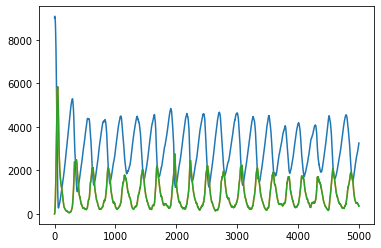

In [70]:
plt.plot(files[0][['Fine', 'On fire', 'trees_on_fire']])
plt.show()